In [1]:
from platform import python_version
python_version()

'3.10.6'

In [2]:
import os, glob, re, pickle
from functools import partial
from collections import OrderedDict
import operator as op
from cytoolz import compose

import pandas as pd
import seaborn as sns
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib as mpl
import matplotlib.pyplot as plt

from pyscenic.export import export2loom, add_scenic_metadata
from pyscenic.utils import load_motifs
from pyscenic.transform import df2regulons
from pyscenic.aucell import aucell
from pyscenic.binarization import binarize
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_binarization, plot_rss

from IPython.display import HTML, display
import loompy as lp

In [3]:
# Set maximum number of jobs for Scanpy.
sc.settings.njobs = 32

In [4]:
os.getcwd()

'/mnt/cho_lab/disk2/jiayuzh/projects/perianal-cd/analysis/scenicplus/scripts'

In [5]:
os.chdir('/mnt/cho_lab/disk2/jiayuzh/projects/perianal-cd/analysis/scenicplus')

Folder Structure

In [6]:
RESOURCES_FOLDERNAME = "./resources/"
AUXILLIARIES_FOLDERNAME = "./auxilliaries/"
RESULTS_FOLDERNAME = "./results/"
FIGURES_FOLDERNAME = "./figures/"

In [7]:
sc.settings.figdir = FIGURES_FOLDERNAME

Auxilliary functions.

In [8]:
BASE_URL = "http://motifcollections.aertslab.org/v10/logos/"
COLUMN_NAME_LOGO = "MotifLogo"
COLUMN_NAME_MOTIF_ID = "MotifID"
COLUMN_NAME_TARGETS = "TargetGenes"

In [9]:
def savesvg(fname: str, fig, folder: str=FIGURES_FOLDERNAME) -> None:
    """
    Save figure as vector-based SVG image format.
    """
    fig.tight_layout()
    fig.savefig(os.path.join(folder, fname), format='svg')

In [10]:
def display_logos(df: pd.DataFrame, top_target_genes: int = 3, base_url: str = BASE_URL):
    """
    :param df:
    :param base_url:
    """
    # Make sure the original dataframe is not altered.
    df = df.copy()
    
    # Add column with URLs to sequence logo.
    def create_url(motif_id):
        return '<img src="{}{}.png" style="max-height:124px;"></img>'.format(base_url, motif_id)
    df[("Enrichment", COLUMN_NAME_LOGO)] = list(map(create_url, df.index.get_level_values(COLUMN_NAME_MOTIF_ID)))
    
    # Truncate TargetGenes.
    def truncate(col_val):
        return sorted(col_val, key=op.itemgetter(1))[:top_target_genes]
    df[("Enrichment", COLUMN_NAME_TARGETS)] = list(map(truncate, df[("Enrichment", COLUMN_NAME_TARGETS)]))
    
    MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
    pd.set_option('display.max_colwidth', -1)
    display(HTML(df.head().to_html(escape=False)))
    pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

Auxilliary data sets.

In [11]:
# Downloaded fromm pySCENIC github repo: https://github.com/aertslab/pySCENIC/tree/master/resources
HUMAN_TFS_FNAME = os.path.join(AUXILLIARIES_FOLDERNAME, 'allTFs_hg38.txt')
# Ranking databases. Downloaded from cisTargetDB: https://resources.aertslab.org/cistarget/
RANKING_DBS_FNAMES = list(map(lambda fn: os.path.join(AUXILLIARIES_FOLDERNAME, fn),
                       ['hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather',
                       'hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather']))
# Motif annotations. Downloaded from cisTargetDB: https://resources.aertslab.org/cistarget/
MOTIF_ANNOTATIONS_FNAME = os.path.join(AUXILLIARIES_FOLDERNAME, 'motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl')

Perianal CD Fistula

In [12]:
DATASET_ID = "AA3_Ileum_RNA"
PROCESS_CODE = "filtered"

Reading in expression data: 10x Genomics mtx files

In [13]:
adata = sc.read_10x_mtx(
    '../scenicplus/resources/AA3_Ileum_RNA/' ,                 # the directory with the `.mtx` file
    var_names='gene_symbols') 

result created

In [14]:
METADATA_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.metadata.csv'.format(DATASET_ID))
EXP_MTX_QC_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.qc.tpm.csv'.format(DATASET_ID))
ADJACENCIES_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.adjacencies.tsv'.format(DATASET_ID))
MOTIFS_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.motifs.csv'.format(DATASET_ID))
REGULONS_DAT_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.regulons.dat'.format(DATASET_ID))
AUCELL_MTX_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.auc.csv'.format(DATASET_ID))
BIN_MTX_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.bin.csv'.format(DATASET_ID))
THR_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.thresholds.csv'.format(DATASET_ID))
ANNDATA_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.h5ad'.format(DATASET_ID))
LOOM_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}_{}.loom'.format(DATASET_ID, PROCESS_CODE))


In [15]:
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 1488 × 36601
    var: 'gene_ids', 'feature_types'

In [16]:
nCountsPerGene = np.sum(adata.X, axis=0)
nCellsPerGene = np.sum(adata.X>0, axis=0)

# Show info
print("Number of counts (in the dataset units) per gene:", nCountsPerGene.min(), " - " ,nCountsPerGene.max())
print("Number of cells in which each gene is detected:", nCellsPerGene.min(), " - " ,nCellsPerGene.max())

Number of counts (in the dataset units) per gene: 0.0  -  269257.0
Number of cells in which each gene is detected: 0  -  1488


STEP 0: Preprocessing

In [16]:
df_metadata = pd.read_table('./resources/meta_PerianalCD_n15.txt')
df_metadata.head()

,cell_id,sample_id,cell_type,cohort,no.of.genes,no.of.reads,patient_id,age,sex,tnf_treatment,fistula_current,inflammation,site,cell_bin
0,AAACCCACAAGGCCTC-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1...,Perianal1_Sig,IgA Plasma,Black,1695,19769,Perianal1,33,Male,No,Yes,Inflamed,Sigmoid,Plasma_Cells
1,AAACCCACAGGACTAG-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1...,Perianal1_Sig,IgG Plasma,Black,1888,35007,Perianal1,33,Male,No,Yes,Inflamed,Sigmoid,Plasma_Cells
2,AAACCCATCCTGTAGA-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1...,Perianal1_Sig,Epithelial,Black,774,1718,Perianal1,33,Male,No,Yes,Inflamed,Sigmoid,Epithelial
3,AAACGAACACATATGC-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1...,Perianal1_Sig,IgG Plasma,Black,1659,17579,Perianal1,33,Male,No,Yes,Inflamed,Sigmoid,Plasma_Cells
4,AAACGAAGTGACCGTC-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1...,Perianal1_Sig,Fibroblasts,Black,929,1830,Perianal1,33,Male,No,Yes,Inflamed,Sigmoid,Stromal


EXPRESSION MATRIX QC

In [17]:
df_obs = df_metadata.set_index('cell_id')
adata.obs = df_obs
adata.var_names_make_unique()

In [17]:
# simply compute the number of genes per cell (computers 'n_genes' column)
sc.pp.filter_cells(adata, min_genes=0)
# mito and genes/counts cuts
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

In [18]:
# initial cuts
sc.pp.filter_cells(adata, min_genes=200 )
sc.pp.filter_genes(adata, min_cells=3 )
adata = adata[adata.obs['n_genes'] < 4000, :]
adata = adata[adata.obs['percent_mito'] < 0.30, :]

Data Normalization

In [19]:


adata.raw = adata
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
adata

/home/cho_lab/jiayu/miniconda3/envs/pyscenic/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 1439 × 4290
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'

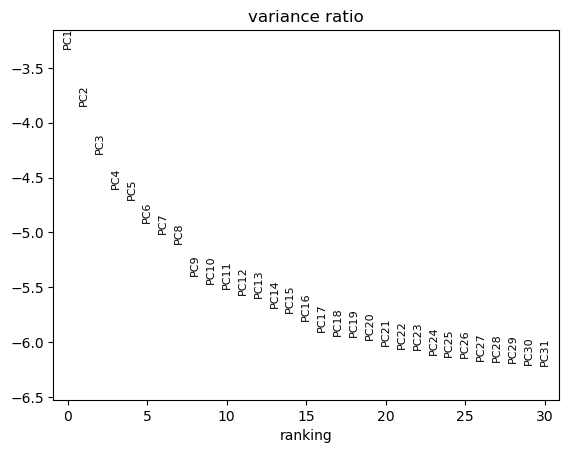

In [20]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

In [21]:
sc.pp.neighbors(adata, n_neighbors=17, n_pcs=10)
sc.tl.umap(adata)

/home/cho_lab/jiayu/miniconda3/envs/pyscenic/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
ANNDATA_FNAME

'./results/AA3_Ileum_RNA.h5ad'

In [23]:
adata.write_h5ad(ANNDATA_FNAME)